In [94]:
import numpy as np
import pandas as pd

import torch
import torch.utils.data

In [96]:
data_pos = pd.read_csv('/media/data/nlp/sentiment/ru-mokoron/positive.csv',
                   names=['id', 'date', 'user', 'text', 'sentiment'], index_col=0,
                   sep=';', usecols=[0, 1, 2, 3, 4])
data_neg = pd.read_csv('/media/data/nlp/sentiment/ru-mokoron/negative.csv',
                   names=['id', 'date', 'user', 'text', 'sentiment'], index_col=0,
                   sep=';', usecols=[0, 1, 2, 3, 4])

data = pd.concat([data_pos, data_neg])

In [100]:
len(data_pos.text), len(set(data_pos.text))

(114911, 110396)

In [65]:
%matplotlib inline
import seaborn
seaborn.set()

In [63]:
max(data.text.str.len()), max(data.text.str.split(' ').str.len())

(189, 94)

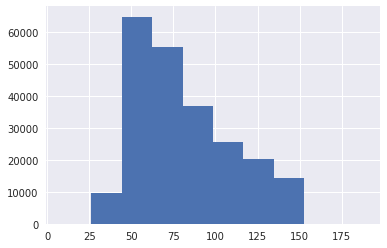

In [70]:
data.text.str.len().hist()

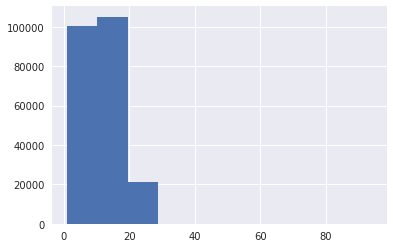

In [69]:
data.text.str.split(' ').str.len().hist()

In [3]:
data.sample(5)

,date,user,text,sentiment
id,,,,
413821004637806593,1387497590,Artem_NS,И как в этом шлюхообразном мире можно найти св...,-1
410848220143972352,1386788823,missdevine_,"среда, 18.12, волейбол. учителя vs лицеисты :)...",1
410792065178812417,1386775435,pennyroyal_teea,@cykaaaa_ я в рязани хочу учиться..в.москву бу...,1
416426390217834496,1388118762,ViktoriaMshn,@strikalo в жизни оскорблять не так просто:(,-1
411127764864217088,1386855472,AvramenkoAnuta,"У меня попугай подпевает музыке, которую я слу...",1


In [98]:
len(data.text), len(set(list(data.text)))

(226834, 217440)

## Train-val-test split

In [8]:
len(data)

226834

In [12]:
indices = list(data.index)
np.random.shuffle(indices)

TEST_SIZE = 0.15
VAL_SIZE = 0.15

test_size = int(len(indices) * TEST_SIZE)
val_size = int(len(indices) * VAL_SIZE)
train_size = len(indices) - test_size - val_size

train_idxs = indices[:train_size]
valid_idxs = indices[train_size:train_size+val_size]
test_idxs = indices[train_size+val_size:]

print('Train: ', train_size)
print('Valid: ', val_size)
print('Test : ', test_size)

Train:  158784
Valid:  34025
Test :  34025


In [14]:
train_data = data.loc[train_idxs]
valid_data = data.loc[valid_idxs]
test_data = data.loc[test_idxs]

In [77]:
basepath = '/media/data/nlp/sentiment/ru-mokoron/splits/'

In [15]:
train_data.to_csv(basepath+'train.csv')
valid_data.to_csv(basepath+'validation.csv')
test_data.to_csv(basepath+'test.csv')

In [79]:
train_data = pd.read_csv(basepath+'train.csv')
valid_data = pd.read_csv(basepath+'validation.csv')
test_data = pd.read_csv(basepath+'test.csv')

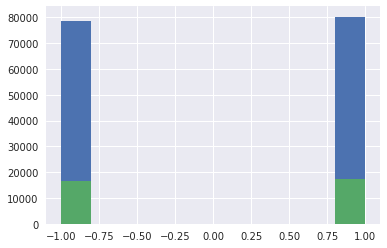

In [88]:
train_data.sentiment.hist()
valid_data.sentiment.hist()

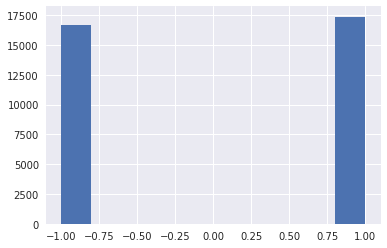

In [87]:
test_data.sentiment.hist()

In [92]:
len(set(valid_data.text).intersection(set(train_data.text)))

1463

In [99]:
len(set(test_data.text).intersection(set(train_data.text)))

1443

In [93]:
len(valid_data)

34025

# Dataset

In [56]:
MAXLEN = 170

ALPHABET = ['<UNK>'] + ['\n'] + [s for s in """ абвгдеёжзийклмнопрстуфхцчщъыьэюя0123456789-,;.!?:'’’/\|_@#$%ˆ&* ̃‘+-=<>()[]{}"""]
ALPHABET += 'abcdefghijklmnopqrstuvwxyz'
ALPHABET_LEN = len(ALPHABET)
char2int = {s: i for s, i in zip(ALPHABET, range(ALPHABET_LEN))}

class MokoronDatasetOneHot(torch.utils.data.Dataset):
    """
    Zero vector for padding.
    """
    noise_level = 0

    def __init__(self, filepath, maxlen=MAXLEN, noise_level=0):
        self.alphabet = ALPHABET

        self.data = pd.read_csv(filepath)
        self.maxlen = maxlen
        self.char2int = {s: i for s, i in zip(self.alphabet, range(len(self.alphabet)))}
        self.noise_level = noise_level

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        line = self.data.iloc[idx]
        if self.noise_level > 0:
            text = self._noise_generator(text)
        text = self._preprocess_text_nobatch(line.text)
        label = int(line.sentiment == 1.)
        return text, label

    def _noise_generator(string):
        noised = ""
        for c in string:
            if random() > self.noise_level:
                noised += c
            if random() < self.noise_level:
                noised += choice(self.alphabet)
        return noised

    def _one_hot(self, char):
        zeros = np.zeros(len(self.alphabet))
        if char in self.char2int:
            zeros[self.char2int[char]] = 1.
        else:
            zeros[self.char2int['<UNK>']] = 1.

    def _preprocess_text_nobatch(self, text):
        text = text.lower()
        one_hotted_text = np.zeros((self.maxlen, len(self.alphabet)))
        for i, char in enumerate(text):
            if i >= self.maxlen:
                break
            one_hotted_text[i, self.char2int.get(char, self.char2int['<UNK>'])] = 1.

        return torch.FloatTensor(one_hotted_text)

    def onehot2text(self, one_hotted_text, show_pad=False):
        text = ''
        max_values, idx = torch.max(one_hotted_text, 1)
        for c, i in enumerate(idx):
            if max_values[c] == 0:
                if show_pad:
                    symb = '<PAD>'
                else:
                    symb = ''
            else:
                symb = ALPHABET[i]
            text += symb
        return text


In [73]:
dataset = MokoronDatasetOneHot(filepath=basepath+'train.csv')

In [76]:
text, sentiment = dataset[10000]
text, sentiment

(
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
        ...          ⋱          ...       
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
     0     0     0  ...      0     0     0
 [torch.FloatTensor of size 512x106], True)

In [59]:
dataset.dataframe.iloc[0].text

'@SPB_citizen @gruppa_GS Сдулися оба.((( \nОдно радует: в семействе Гудковых не наблюдается конфликта отцов и детей.'

In [60]:
dataset.onehot2text(text)

'@spb_citizen @gruppa_gs сдулися оба.((( \nодно радует: в семействе гудковых не наблюдается конфликта отцов и детей.'

In [ ]:
MAX_WORD_LEN = 8
MAX_TEXT_LEN = 256

ALPHABET = ['<UNK>'] + ['\n'] + [s for s in """ абвгдеёжзийклмнопрстуфхцчщъыьэюя0123456789-,;.!?:'’’/\|_@#$%ˆ&* ̃‘+-=<>()[]{}"""]
ALPHABET += 'abcdefghijklmnopqrstuvwxyz'
ALPHABET_LEN = len(ALPHABET)
char2int = {s: i for s, i in zip(ALPHABET, range(ALPHABET_LEN))}

class MokoronDatasetHieracial(torch.utils.data.Dataset):
    """
    Zero vector for padding.
    """
    noise_level = 0

    def __init__(self, filepath, maxwordlen=8, maxtextlen=128, noise_level=0):
        self.alphabet = ALPHABET

        self.data = pd.read_csv(filepath)
        self.maxwordlen = maxwordlen
        self.maxtextlen = maxtextlen
        self.char2int = {s: i for s, i in zip(self.alphabet, range(len(self.alphabet)))}
        self.noise_level = noise_level

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        line = self.data.iloc[idx]
        if self.noise_level > 0:
            text = self._noise_generator(text)
        text = self._preprocess_text_nobatch(line.text)
        label = int(line.sentiment == 1.)
        return text, label

    def _noise_generator(string):
        noised = ""
        for c in string:
            if random() > self.noise_level:
                noised += c
            if random() < self.noise_level:
                noised += choice(self.alphabet)
        return noised

    def _one_hot(self, char):
        zeros = np.zeros(len(self.alphabet))
        if char in self.char2int:
            zeros[self.char2int[char]] = 1.
        else:
            zeros[self.char2int['<UNK>']] = 1.

    def _preprocess_text_nobatch(self, text):
        text = text.lower()
        one_hotted_text = np.zeros((self.maxlen, len(self.alphabet)))
        for i, char in enumerate(text):
            if i >= self.maxlen:
                break
            one_hotted_text[i, self.char2int.get(char, self.char2int['<UNK>'])] = 1.

        return torch.FloatTensor(one_hotted_text)

    def onehot2text(self, one_hotted_text, show_pad=False):
        text = ''
        max_values, idx = torch.max(one_hotted_text, 1)
        for c, i in enumerate(idx):
            if max_values[c] == 0:
                if show_pad:
                    symb = '<PAD>'
                else:
                    symb = ''
            else:
                symb = ALPHABET[i]
            text += symb
        return text
